In [1]:
import pandas as pd
import quandl
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import math
import numpy as np
from sklearn.model_selection import KFold, train_test_split, GridSearchCV 

In [2]:
#df = quandl.get("WGC/GOLD_DAILY_USD")
raw_data = quandl.get('BITFINEX/BTCUSD')

In [3]:
df = raw_data.drop(['High','Low','Last','Bid','Ask'], axis=1)
df.columns = ['Value', 'Volume']
df.head()

,Value,Volume
Date,,
2014-04-15,504.23500,21013.584774
2014-04-16,537.50000,29633.358705
2014-04-17,507.02000,20709.783819
2014-04-18,483.77000,10458.045243
2014-04-19,505.01065,8963.618369


In [4]:
df['day'] = df.index.to_series()

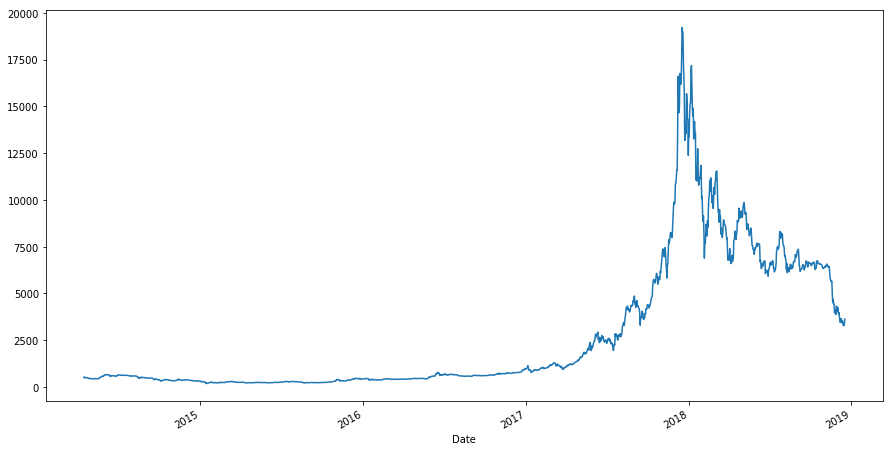

In [5]:
plt.rcParams['figure.figsize'] = [15, 8]
#df.loc[mask].Value.plot.line();
df.Value.plot.line();
#df.loc[mask].Value.rolling(window=50).mean().plot.line()
#df.loc[mask].Value.rolling(window=70).mean().plot.line()

In [6]:
df.head()

,Value,Volume,day
Date,,,
2014-04-15,504.23500,21013.584774,2014-04-15
2014-04-16,537.50000,29633.358705,2014-04-16
2014-04-17,507.02000,20709.783819,2014-04-17
2014-04-18,483.77000,10458.045243,2014-04-18
2014-04-19,505.01065,8963.618369,2014-04-19


#### Feature engineering

In [7]:
## Date features
df_features = df.copy()
df_features['dayofmonth'] = df_features.day.dt.day
df_features['dayofweek'] = df_features.day.dt.dayofweek
df_features['month'] = df_features.day.dt.month
df_features['year'] = df_features.day.dt.year
df_features = df_features.drop(['day'],axis=1)
df_features.head()

,Value,Volume,dayofmonth,dayofweek,month,year
Date,,,,,,
2014-04-15,504.23500,21013.584774,15,1,4,2014
2014-04-16,537.50000,29633.358705,16,2,4,2014
2014-04-17,507.02000,20709.783819,17,3,4,2014
2014-04-18,483.77000,10458.045243,18,4,4,2014
2014-04-19,505.01065,8963.618369,19,5,4,2014


In [8]:
#### Value features
#for i in range(1,4):
#    df_features['value_d-'+str(i)] = df_features['Value'].shift(i)

df_features['small_MA'] = df.Value.rolling(window=18).mean()
df_features['big_MA'] = df.Value.rolling(window=27).mean()

# retira os primeiros registros após o shift, pois esses possuem NaN em suas colunas
df_features.dropna(inplace=True)

In [9]:
df_features.head()

,Value,Volume,dayofmonth,dayofweek,month,year,small_MA,big_MA
Date,,,,,,,,
2014-05-12,439.405,3454.204641,12,0,5,2014,448.651717,466.415622
2014-05-13,438.405,1913.687047,13,1,5,2014,445.369217,463.977474
2014-05-14,447.200,3086.767474,14,2,5,2014,444.387411,460.633030
2014-05-15,446.685,1892.639528,15,3,5,2014,443.742133,458.398400
2014-05-16,448.425,1733.440949,16,4,5,2014,443.893244,457.089326


In [10]:
df_features.columns

Index(['Value', 'Volume', 'dayofmonth', 'dayofweek', 'month', 'year',
       'small_MA', 'big_MA'],
      dtype='object')

In [11]:
feats = df_features.columns
feats = feats[1:]
feats

Index(['Volume', 'dayofmonth', 'dayofweek', 'month', 'year', 'small_MA',
       'big_MA'],
      dtype='object')

### Random Forest + Kfold split

In [12]:
kf = KFold(n_splits=6,shuffle=True,random_state=0)

In [13]:
df_features_no_index = df_features#.reset_index(drop=True) 

In [14]:
reg = RandomForestRegressor(max_depth = 5, random_state=42, n_estimators = 100)

In [15]:
for k, (train_index, test_index) in enumerate(kf.split(df_features_no_index)):
    print("Rodando k:", k)
    train, test = df_features_no_index.iloc[train_index], df_features_no_index.iloc[test_index]
    
    train_X = train[feats]
    train_y = train['Value']
    
    test_X = test[feats]
    test_y = test['Value']
    
    reg.fit(train_X, train_y)
    
    train_predict_k = reg.predict(train_X)
    test_predict_k = reg.predict(test_X)
    
    print("Train:")
    print("Mean squared error: %.2f"
      % mean_squared_error(train_y, train_predict_k))

    print("Root Mean squared error: %.2f"
      % math.sqrt(mean_squared_error(train_y, train_predict_k)))

    print('R2 score: %.2f' % r2_score(train_y, train_predict_k))
    
    print("\nTest:")
    print("Mean squared error: %.2f"
      % mean_squared_error(test_y, test_predict_k))

    print("Root Mean squared error: %.2f"
      % math.sqrt(mean_squared_error(test_y, test_predict_k)))

    print('R2 score: %.2f' % r2_score(test_y, test_predict_k))
    
    print("----------------")

Rodando k: 0
Train:
Mean squared error: 109744.16
Root Mean squared error: 331.28
R2 score: 0.99

Test:
Mean squared error: 158264.92
Root Mean squared error: 397.83
R2 score: 0.99
----------------
Rodando k: 1
Train:
Mean squared error: 114623.79
Root Mean squared error: 338.56
R2 score: 0.99

Test:
Mean squared error: 148764.08
Root Mean squared error: 385.70
R2 score: 0.99
----------------
Rodando k: 2
Train:
Mean squared error: 111931.87
Root Mean squared error: 334.56
R2 score: 0.99

Test:
Mean squared error: 291038.59
Root Mean squared error: 539.48
R2 score: 0.98
----------------
Rodando k: 3
Train:
Mean squared error: 99695.50
Root Mean squared error: 315.75
R2 score: 0.99

Test:
Mean squared error: 167759.40
Root Mean squared error: 409.58
R2 score: 0.99
----------------
Rodando k: 4
Train:
Mean squared error: 99984.39
Root Mean squared error: 316.20
R2 score: 0.99

Test:
Mean squared error: 199510.72
Root Mean squared error: 446.67
R2 score: 0.99
----------------
Rodando k: 5

### Novo split do dataset

In [16]:
# split into train and test sets
train_size = int(len(df_features) * 0.9)
test_size = len(df_features) - train_size
train = df_features[:train_size]
test = df_features[train_size:]

In [17]:
len(train), len(test), len(train) + len(test)

(1478, 165, 1643)

In [18]:
# aproveita o modelo treinado com kfold
#reg = RandomForestRegressor(max_depth=5, random_state=42,n_estimators=100)
#reg.fit(train[feats], train['Value'])

In [19]:
trainPredict = reg.predict(train[feats])
testPredict = reg.predict(test[feats])

In [20]:
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(test['Value'], testPredict))

# RMSE
print("Root Mean squared error: %.2f"
      % math.sqrt(mean_squared_error(test['Value'], testPredict)))

# Explained variance score: 1 is perfect prediction
print('R2 score: %.2f' % r2_score(test['Value'], testPredict))

Mean squared error: 194095.68
Root Mean squared error: 440.56
R2 score: 0.86


In [21]:
#for i in range(50):
#    trainPredict = np.insert(trainPredict, 0, [np.NaN])

for i in range(len(trainPredict)):
    testPredict = np.insert(testPredict, 0, [np.NaN])

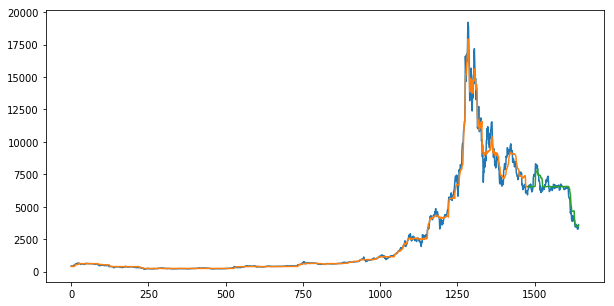

In [28]:
 # plot baseline and predictions
plt.plot(df_features['Value'].values)
plt.plot(trainPredict)
plt.plot(testPredict)
plt.rcParams['figure.figsize'] = [15, 8]
plt.show()

In [23]:
estimator = reg.estimators_[9]

In [24]:
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, 
                out_file='tree.dot', 
                feature_names = feats,
                class_names = df_features['Value'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

In [25]:
# Convert to png
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

0

In [26]:
# Display in jupyter notebook
#from IPython.display import Image
#Image(filename = 'data/tree.png')

Feature ranking:
1. feature small_MA (0.948427)
2. feature big_MA (0.037819)
3. feature month (0.005623)
4. feature year (0.004406)
5. feature dayofmonth (0.002280)
6. feature Volume (0.001197)
7. feature dayofweek (0.000247)


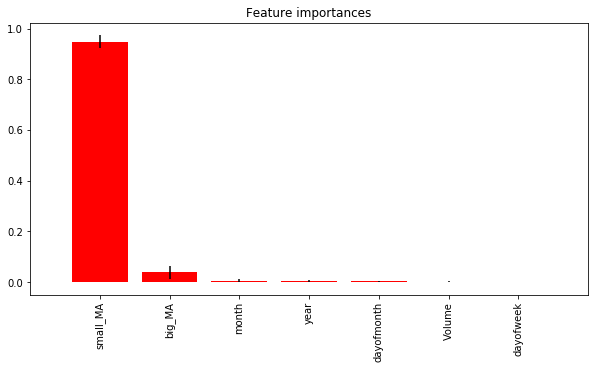

In [27]:
plt.rcParams['figure.figsize'] = [10, 5]
importances = reg.feature_importances_
std = np.std([tree.feature_importances_ for tree in reg.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(train[feats].shape[1]):
    print("%d. feature %s (%f)" % (f + 1, train[feats].columns[indices[f]], importances[indices[f]]))

    
path_to_images = 'img/'
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(train[feats].shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(train[feats].shape[1]), train[feats].columns[indices],rotation=90)
plt.xlim([-1, train[feats].shape[1]])
plt.savefig(path_to_images + 'importancia_features_regressor.png', bbox_inches='tight')
plt.show()